## Sentiment Analysis Hotel Review
Data source: https://www.kaggle.com/anu0012/hotel-review

#### Import Lib and Load Data

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.utils.multiclass import unique_labels


C:\Users\Acer\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('train.csv')

#### EDA
Let's get to know with this data!

In [3]:
df.shape

(38932, 5)

In [4]:
df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [5]:
df.describe()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
count,38932,38932,38932,38932,38932
unique,38932,38932,11,3,2
top,id45236,this was a nice hotel. the staff was great and...,Firefox,Desktop,happy
freq,1,1,7367,15026,26521


In [6]:
df['Is_Response'].value_counts()

happy        26521
not happy    12411
Name: Is_Response, dtype: int64

happy        68.12
not happy    31.88
Name: Is_Response, dtype: float64


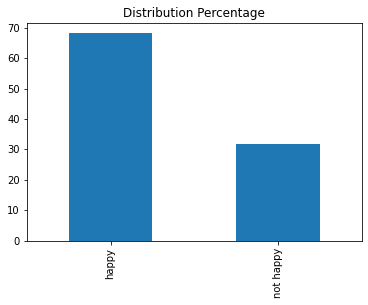

In [7]:
print(round(df.Is_Response.value_counts(normalize=True)*100,2))
round(df.Is_Response.value_counts(normalize=True)*100,2).plot(kind='bar')
plt.title('Distribution Percentage')
plt.show()

In [8]:
# map label into 0 and 1
mapping_target = {'happy':0, 'not happy':1}
df = df.replace({'Is_Response':mapping_target})
df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,1
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,1
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,1
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,0
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,1


In [9]:
df.isna().sum()
# perfect

User_ID         0
Description     0
Browser_Used    0
Device_Used     0
Is_Response     0
dtype: int64

From here, we would like to divide independent and dependent variables. Independent var is Description and dependent var is Is_Response. The others variable is not relevant with the response that made by users.

#### Preprocessing

In [10]:
# remove links
def remove_links(tweet):
  '''Takes a string and removes web links from it'''
  tweet = re.sub(r'http\S+', '', tweet) # remove http links
  tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
  tweet = tweet.strip('[link]') # remove [links]
  return tweet

In [11]:
def clean_html(text):
  html = re.compile('<.*?>')#regex
  return html.sub(r'',text)

In [12]:
# remove non-ascii character
def non_ascii(s):
  return "".join(i for i in s if ord(i)<128)

def lower(text):
  return text.lower()

In [13]:
# remove stopwords
def removeStopWords(str):
#select english stopwords
  cachedStopWords = set(stopwords.words("english"))
#add custom words
  cachedStopWords.update(('and','I','A','http','And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these','mailto','regards','ayanna','like','email'))
#remove stop words
  new_str = ' '.join([word for word in str.split() if word not in cachedStopWords]) 
  return new_str 

In [14]:
# remove email adresses, using RegEx
def email_address(text):
  email = re.compile(r'[\w\.-]+@[\w\.-]+')
  return email.sub(r'',text)

def punct(text):
  token=RegexpTokenizer(r'\w+')#regex
  text = token.tokenize(text)
  text= " ".join(text)
  return text 

In [15]:
# remove digits, special character, '_'
def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    #when the ^ is on the inside of []; we are matching any character that is not included in this expression within the []
    return re.sub(pattern, '', text)

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_(tweet):
  tweet = re.sub('([_]+)', "", tweet)
  return tweet

In [16]:
df['newDescription'] = df.Description.apply(func = clean_html)
df['newDescription'] = df.newDescription.apply(func = non_ascii)
df['newDescription'] = df.newDescription.apply(func = lower)
df['newDescription'] = df.newDescription.apply(func = email_address)
df['newDescription'] = df.newDescription.apply(func = removeStopWords)
df['newDescription'] = df.newDescription.apply(func = clean_html)
df['newDescription'] = df.newDescription.apply(func = punct)
df['newDescription'] = df.newDescription.apply(func = remove_)

In [17]:
df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response,newDescription
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,1,room kind clean strong smell dogs generally av...
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,1,stayed crown plaza april april staff friendly ...
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,1,booked hotel hotwire lowest price could find g...
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,0,stayed husband sons way alaska cruise loved ho...
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,1,girlfriends stayed celebrate th birthdays plan...


In [18]:
df['Description'][1]

"I stayed at the Crown Plaza April -- - April --, ----. The staff was friendly and attentive. The elevators are tiny (about -' by -'). The food in the restaurant was delicious but priced a little on the high side. Of course this is Washington DC. There is no pool and little for children to do. My room on the fifth floor had two comfortable beds and plenty of space for one person. The TV is a little small by todays standards with a limited number of channels. There was a small bit of mold in the bathtub area that could have been removed with a little bleach. It appeared the carpets were not vacummed every day. I reported a light bulb was burned out. It was never replaced. Ice machines are on the odd numbered floors, but the one on my floor did not work. I encountered some staff in the elevator one evening and I mentioned the ice machine to them. Severel hours later a maid appeared at my door with ice and two mints. I'm not sure how they knew what room I was in. That was a little unnervi

In [19]:
df['newDescription'][1]

'stayed crown plaza april april staff friendly attentive elevators tiny about food restaurant delicious priced little high side course washington dc pool little children do room fifth floor two comfortable beds plenty space one person tv little small todays standards limited number channels small bit mold bathtub area could removed little bleach appeared carpets vacummed every day reported light bulb burned out never replaced ice machines odd numbered floors one floor work encountered staff elevator one evening mentioned ice machine them severel hours later maid appeared door ice two mints i m sure knew room in little unnerving would stay business would come vacation'

#### Train Test Split
90:10 for training and testing

In [20]:
X, y = df['newDescription'], df['Is_Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"X_train: {len(X_train)}")
print(f"X_test: {len(X_test)}")
print(f"y_train: {len(y_train)}")s
print(f"y_test: {len(y_test)}")

X_train: 35038
X_test: 3894
y_train: 35038
y_test: 3894


#### TF-IDF and Classifier
We will use bow with tf-idf vectorizer for extracting features by converting the cleaned review to a matrix of tf-idf features.  
We will use two classifier and compare it:
1. Logistic Regression
2. Random Forest Classifier

In [22]:
vec = TfidfVectorizer()
cls_lg = LogisticRegression(solver='lbfgs', max_iter=1000)

model = Pipeline([('vectorizer', vec), ('classifier', cls_lg)])

In [23]:
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(max_iter=1000))])

In [50]:
from sklearn.ensemble import RandomForestClassifier
cls_rf = RandomForestClassifier()
model2 = Pipeline([('vectorizer', vec), ('classifier', cls_rf)])

In [45]:
model2.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [41]:
from sklearn.tree import DecisionTreeClassifier
cls_dt = DecisionTreeClassifier()
model3 = Pipeline([('vectorizer', vec), ('classifier', cls_dt)])

In [42]:
model3.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', DecisionTreeClassifier())])

### Evaluation
We compute accuracy, precision, and recall. Also, we plot a confusion martrix to get better understanding about the model's performance. We evaluate the model using testing data (0.1).

In [71]:
y_pred = model.predict(X_test)

print('Linear Regression')
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'Precision: {precision_score(y_pred, y_test, average="weighted")}')
print(f'Recall: {recall_score(y_pred, y_test, average="weighted")}')

Linear Regression
Accuracy: 0.8849512069851053
Precision: 0.8901953587765573
Recall: 0.8849512069851053


In [46]:
y_pred1 = model2.predict(X_test)

print('Random Forest')
print(f'Accuracy: {accuracy_score(y_pred1, y_test)}')
print(f'Precision: {precision_score(y_pred1, y_test, average="weighted")}')
print(f'Recall: {recall_score(y_pred1, y_test, average="weighted")}')

Random Forest
Accuracy: 0.8333333333333334
Precision: 0.8902900389781095
Recall: 0.8333333333333334


In [43]:
y_pred2 = model3.predict(X_test)

print('Decision Tree')
print(f'Accuracy: {accuracy_score(y_pred2, y_test)}')
print(f'Precision: {precision_score(y_pred2, y_test, average="weighted")}')
print(f'Recall: {recall_score(y_pred2, y_test, average="weighted")}')

Decision Tree
Accuracy: 0.75115562403698
Precision: 0.751424254242098
Recall: 0.75115562403698


Linear Regression model is the best among the others.

In [29]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,4), fontsize=12, model='cls'):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a seaborn heatmap. 
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)   
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()

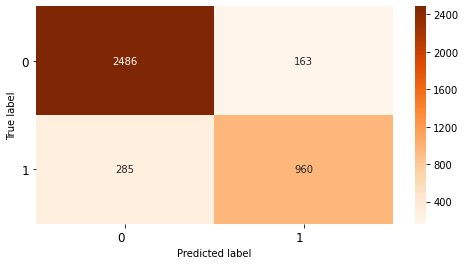

In [30]:
confmat = confusion_matrix(y_test, y_pred)
uniqlabels = unique_labels(y_test, y_pred)

print_confusion_matrix(confmat, uniqlabels)

### Additional
We can compare some algorithms by using this way. We will make search_space that contains all algorithm that we want to compare.
In this case, we will compare Multinomial Naive Bayes, Linear Support Vector Machine, and K-Nearest Neighbor Classifier.
We also use GridSearchCV for validation. In this case we will use 5 cross validation.

In [47]:
# define first pipeline, which is MultinomialNB
from sklearn.naive_bayes import MultinomialNB
cls_nb = MultinomialNB()
modelnb = Pipeline([('vectorizer', vec), ('classifier', cls_nb)])

In [49]:
from sklearn.svm import LinearSVC
cls_svm = LinearSVC()

In [51]:
from sklearn.neighbors import KNeighborsClassifier
cls_knn = KNeighborsClassifier()

In [52]:
# input algorithm to the search_space
search_space = [{"classifier": [MultinomialNB()]},
                {"classifier": [LinearSVC()]},
                {"classifier": [LogisticRegression()],"classifier__solver": ["liblinear"]},
                {"classifier": [KNeighborsClassifier()], "classifier__n_neighbors": [5, 6, 7, 8]}]

In [53]:
# GridSearchCV + model training for each algorithm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
scoring = {'AUC': 'roc_auc', 'Accuracy': metrics.make_scorer(metrics.accuracy_score)}
grid = GridSearchCV(estimator=modelnb, param_grid=search_space, cv=5, scoring=scoring,
                    return_train_score=True, n_jobs=-1, refit="AUC")
best_model = grid.fit(X_train, y_train)

C:\Users\Acer\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [0.92200346 0.93423223 0.94175489        nan        nan        nan
        nan]
  category=UserWarning,
C:\Users\Acer\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the train scores are non-finite: [0.94419224 0.99272286 0.96537132        nan        nan        nan
        nan]
  category=UserWarning,
C:\Users\Acer\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [0.80826541 0.87562072 0.88441132        nan        nan        nan
        nan]
  category=UserWarning,
C:\Users\Acer\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the train scores are non-finite: [0.82937097 0.96567298 0.91289457        nan        nan        nan
        nan]
  category=UserWarning,


In [60]:
best_model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'classifier': [MultinomialNB()]},
                         {'classifier': [LinearSVC()]},
                         {'classifier': [LogisticRegression(solver='liblinear')],
                          'classifier__solver': ['liblinear']},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [5, 6, 7, 8]}],
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [56]:
print("Best: %f using %s" % (best_model.best_score_, best_model.best_params_))

Best: 0.941755 using {'classifier': LogisticRegression(solver='liblinear'), 'classifier__solver': 'liblinear'}


Logistic Regression still outperformed the others. Next, we will predict using X_test, and also evaluate using accuracy, precision, recall, and confusion matrix.

In [54]:
# Test the model
pred = best_model.predict(X_test)

In [58]:
# Print accuracy score
print("Best Model Accuracy: %0.3f" % metrics.accuracy_score(y_test, pred))
print("Best Model Precision: %0.3f" % metrics.precision_score(y_test, pred))
print("Best Model Recall: %0.3f" % metrics.recall_score(y_test, pred))

Best Model Accuracy: 0.885
Best Model Precision: 0.855
Best Model Recall: 0.771


In [62]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,4), fontsize=12, model='best_model'):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a seaborn heatmap. 
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)   
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()

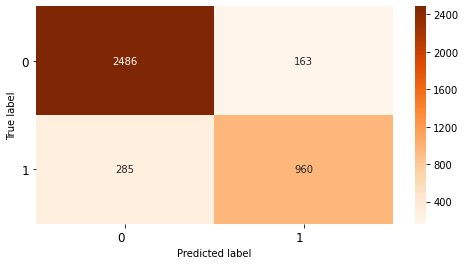

In [73]:
confmat = confusion_matrix(y_test, y_pred)
uniqlabels = unique_labels(y_test, y_pred)

print_confusion_matrix(confmat, uniqlabels)

In [72]:
# Calculate the confusion matrix for the best model
best_cm = metrics.confusion_matrix(y_test, pred)
best_cm

array([[2486,  163],
       [ 285,  960]], dtype=int64)

From the confusion matrix above, is still same with our first attempt in early of this section.